# LSTM 예제 코드 필사하고 이해하기 - Part 2

<br>

<br>

#### 참고한 LSTM Code
[Pytorch ver.1](https://cnvrg.io/pytorch-lstm/?gclid=Cj0KCQiA6t6ABhDMARIsAONIYyxsIXn6G6EcMLhGnPDxnsKiv3zLU49TRMxsyTPXZmOV3E-Hh4xeI2EaAugLEALw_wcB)
<br>
[Pytorch ver.2](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

## 1. Load and understand dataset

In [2]:
flight = sns.load_dataset('flights')
flight.head(3)

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132


In [3]:
flight.shape

(144, 3)

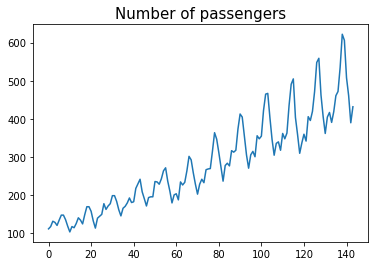

In [6]:
plt.plot(flight['passengers'])
plt.title('Number of passengers', fontsize = 15)
plt.show()

## 2. Data Preprocessing

In [7]:
all_data = flight['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [9]:
#train and test data
test_size = 12

train_data = all_data[:-test_size]
test_data = all_data[-test_size:]

print(len(train_data))
print(len(test_data))

132
12


In [11]:
# scaling data
scaler = MinMaxScaler(feature_range = (-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

### Convert numpy data to tensor
Numpy형 데이터를 pytorch 모델링을 위한 Tensor 형태로 변환한다. `FloatTensor`은 float형 tensor로 변환하는 메소드이다. 이 때, `torch.FloatTensor(train_data_normalized)`만 적용하면 data shape이 [132, 1]이 되는데 이 형태로는 데이터를 가공하는데 나중에 무리가 있기 때문에 1D tensor로 변환한다. `view(-1)`을 적용하면 [132] shape으로 된다.

In [17]:
# convert to Tentsor
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

## 3. Create input sequence
Pytorch ver.2가 ver.1과 다른 점은 **sequence**를 나누어서 모델을 학습했다는 것이다.
<br>
<br>
 + flight data는 월 단위로 구성되어있는데, 본 LSTM 모델에서는 총 12개월 단위(연 단위)로 시퀀스를 생성하고 시퀀스들을 모델에 차례차례 넣어서 학습하는 구조로 모델을 구축하였다.
 + 또 다른 특징은 12개의 시퀀스를 이용해 12+1번째 데이터를 label로 설정하여 이를 예측하는 모델로 구현했다는 점이다.
 + 길이 12 시퀀스를 여러개 생성한 후, 합쳐서 최종 input sequence를 생성한다.

In [37]:
def create_input_sequences(input_data, seq):
    inout_seq = []
    L = len(input_data)
    for i in range(L-seq):
        train_seq = input_data[i:i+seq] # train sequence of length 12
        train_label = input_data[i+seq:i+seq+1] # train labels
        inout_seq.append((train_seq, train_label))
        
    return inout_seq

In [21]:
train_inout_seq = create_input_sequences(train_data_normalized, 12)
train_inout_seq

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077])),
 (tensor([-0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385, -0.9516,
          -0.9033, -0.8374, -0.8637, -0.9077]),
  tensor([-0.8022])),
 (tensor([-0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385, -0.9516, -0.9033,
      

## 4. LSTM model

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 100, output_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)) # initial hidden and cell state
        
    def forward(self, input_seq):
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell) # [12, 1, 1]
        predictions = self.linear(lstm_out.view(len(input_seq), -1)) # [12, 1]
        return predictions[-1]

In [34]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

앞서 input data를 sequence로 나누어 구성했기 때문에 sequence 별로 LSTM 모델을 이용해 prediction을 한다. 매 prediction 과정마다 back propagation을 통해 model 가중치를 update 한다.

In [36]:
epochs = 50
for i in range(epochs):
    for seq, label in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_size), torch.zeros(1, 1, model.hidden_size))
        
        y_pred = model.forward(seq)
        
        loss = loss_function(y_pred, label)
        loss.backward()
        optimizer.step()
    
    if i%10 == 0:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')     

epoch:   0 loss: 0.00209720
epoch:  10 loss: 0.03653868
epoch:  20 loss: 0.02008780
epoch:  30 loss: 0.00575413
epoch:  40 loss: 0.00110275
epoch:  49 loss: 0.0042838366
